# Candlestick + Technicals Notebook
Prepared for a DataFrame with columns:
`date, open, high, low, close, adj_close, volume, daily_return, adj_close_lag1, adj_close_lag2, adj_close_lag3, daily_return_lag1, daily_return_lag2, daily_return_lag3, EMA_20, EMA_50, MACD, MACD_signal, MACD_diff, RSI_14, Stoch_k, Stoch_d, ROC_10, BB_high, BB_low, BB_mid, BB_width, ATR_14, OBV, Volume_SMA_20, MFI_14, Close_to_EMA20, High_Low_Spread`

Each section is separated into its own cell for clarity.

## 1) Imports & Config

In [1]:

# If running first time, you might need: pip install mplfinance plotly
import pandas as pd
import numpy as np
import mplfinance as mpf
from pathlib import Path

# Path to your CSV (edit this)
DATA_CSV = Path('../../../data/processed/nvda_target_updown.csv')

pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 50)
print('Using file:', DATA_CSV)


Using file: ../../../data/processed/nvda_target_updown.csv


## 2) Load & basic cleaning

In [9]:

# Load
df = pd.read_csv(DATA_CSV)

# Ensure datetime index
date_col = None
for c in df.columns:
    if c.lower() == 'date':
        date_col = c
        break
if date_col is None:
    raise ValueError("No 'date' column found.")
df = df[df['date'] > '2025-10-01']

df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col]).set_index(date_col).sort_index()

# Normalize OHLCV names to mplfinance's case-sensitive expectations
rename_map = {}
for want, have in [('Open','open'),('High','high'),('Low','low'),('Close','close'),('Volume','volume')]:
    lower_cols = {c.lower(): c for c in df.columns}
    if have in lower_cols:
        rename_map[lower_cols[have]] = want
df = df.rename(columns=rename_map)

# Make sure numeric columns are numeric
for col in ['Open','High','Low','Close','Volume','EMA_20','EMA_50','MACD','MACD_signal','MACD_diff',
            'RSI_14','Stoch_k','Stoch_d','ROC_10','BB_high','BB_low','BB_mid','BB_width','ATR_14',
            'OBV','Volume_SMA_20','MFI_14','Close_to_EMA20','High_Low_Spread']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows missing core OHLC
df = df.dropna(subset=['Open','High','Low','Close'])
df.head(3)


,Open,High,Low,Close,adj_close,Volume,daily_return,adj_close_lag1,adj_close_lag2,adj_close_lag3,daily_return_lag1,daily_return_lag2,daily_return_lag3,EMA_20,EMA_50,MACD,MACD_signal,MACD_diff,RSI_14,Stoch_k,Stoch_d,ROC_10,BB_high,BB_low,BB_mid,BB_width,ATR_14,OBV,Volume_SMA_20,MFI_14,Close_to_EMA20,High_Low_Spread,y_price_return_1d,y_updown_1d
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-10-02,189.600006,191.050003,188.059998,188.889999,188.889999,136805800,0.008812,187.240005,186.580002,181.850006,0.003537,0.026010,0.020540,179.793252,174.526960,2.856682,1.565144,1.291538,65.598911,90.459348,93.944101,7.177709,189.223280,166.141869,177.682574,23.081411,5.232596,54653148000,183194305.0,61.444783,0.050596,0.015829,-0.006724,-1
2025-10-03,189.190002,190.360001,185.380005,187.619995,187.619995,137596900,-0.006724,188.889999,187.240005,186.580002,0.008812,0.003537,0.026010,180.538656,175.040413,3.117429,1.875601,1.241828,63.145847,84.849788,90.249195,6.197995,189.934124,167.491965,178.713045,22.442159,5.214554,54515551100,178852080.0,61.470539,0.039223,0.026543,-0.011086,-1
2025-10-06,185.500000,187.229996,183.330002,185.539993,185.539993,157678100,-0.011086,187.619995,188.889999,187.240005,-0.006724,0.008812,0.003537,181.014974,175.452161,3.120265,2.124534,0.995731,59.238690,75.662500,83.657212,1.051137,190.090621,169.059417,179.575019,21.031204,5.148514,54357873000,178547530.0,60.883724,0.024998,0.021020,-0.002695,0


## 3) Inspect available columns

In [10]:

available_cols = list(df.columns)
available_cols[:40], len(available_cols)


(['Open',
  'High',
  'Low',
  'Close',
  'adj_close',
  'Volume',
  'daily_return',
  'adj_close_lag1',
  'adj_close_lag2',
  'adj_close_lag3',
  'daily_return_lag1',
  'daily_return_lag2',
  'daily_return_lag3',
  'EMA_20',
  'EMA_50',
  'MACD',
  'MACD_signal',
  'MACD_diff',
  'RSI_14',
  'Stoch_k',
  'Stoch_d',
  'ROC_10',
  'BB_high',
  'BB_low',
  'BB_mid',
  'BB_width',
  'ATR_14',
  'OBV',
  'Volume_SMA_20',
  'MFI_14',
  'Close_to_EMA20',
  'High_Low_Spread',
  'y_price_return_1d',
  'y_updown_1d'],
 34)

## 4) Base candlestick (no indicators)

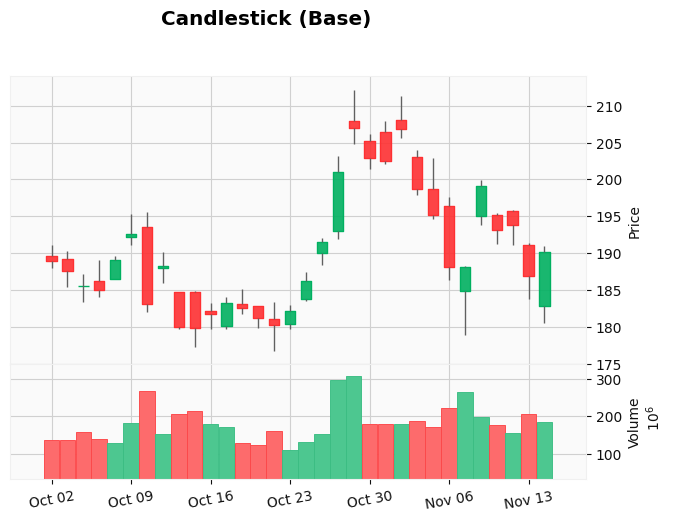

In [11]:

mpf.plot(
    df[['Open','High','Low','Close'] + (['Volume'] if 'Volume' in df.columns else [])],
    type='candle',
    volume=('Volume' in df.columns),
    style='yahoo',
    title='Candlestick (Base)',
    ylabel='Price',
    ylabel_lower='Volume' if 'Volume' in df.columns else None,
    xrotation=10
)


## 5) Price overlays: EMA + Bollinger Bands

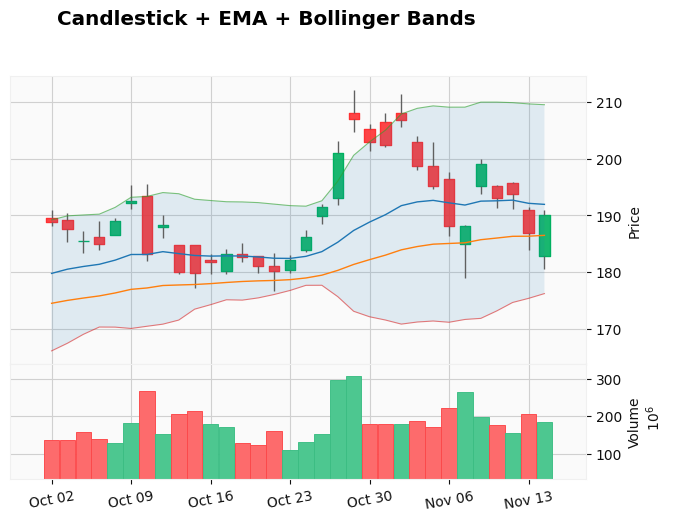

In [12]:

apds = []

# EMA overlays
if 'EMA_20' in df.columns:
    apds.append(mpf.make_addplot(df['EMA_20'], panel=0, width=1))
if 'EMA_50' in df.columns:
    apds.append(mpf.make_addplot(df['EMA_50'], panel=0, width=1))

# Bollinger Bands: shaded region using BB_mid as anchor (safer for mplfinance)
has_bb_hi = 'BB_high' in df.columns
has_bb_lo = 'BB_low' in df.columns
has_bb_mid = 'BB_mid' in df.columns

if has_bb_hi and has_bb_lo and has_bb_mid:
    apds.append(
        mpf.make_addplot(
            df['BB_mid'],
            panel=0,
            color='none',  # invisible line; used as anchor for fill_between
            fill_between=dict(
                y1=df['BB_low'].values,
                y2=df['BB_high'].values,
                alpha=0.12
            )
        )
    )
    # optionally draw the band edges
    apds.append(mpf.make_addplot(df['BB_high'], panel=0, width=0.8, alpha=0.6))
    apds.append(mpf.make_addplot(df['BB_low'],  panel=0, width=0.8, alpha=0.6))
elif has_bb_hi and has_bb_lo:
    # Fallback: just plot the lines without fill
    apds.append(mpf.make_addplot(df['BB_high'], panel=0, width=0.8, alpha=0.6))
    apds.append(mpf.make_addplot(df['BB_low'],  panel=0, width=0.8, alpha=0.6))

mpf.plot(
    df[['Open','High','Low','Close'] + (['Volume'] if 'Volume' in df.columns else [])],
    type='candle',
    volume=('Volume' in df.columns),
    addplot=apds,
    style='yahoo',
    title='Candlestick + EMA + Bollinger Bands',
    ylabel='Price',
    ylabel_lower='Volume' if 'Volume' in df.columns else None,
    xrotation=10
)


## 6) MACD panel

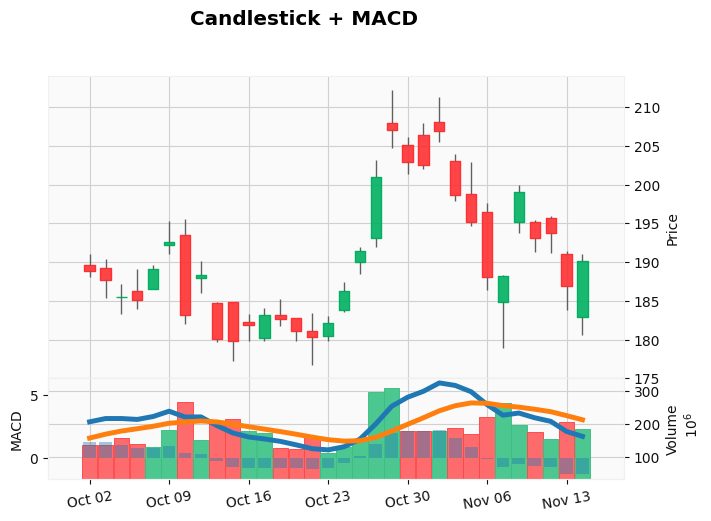

In [13]:

apds = []
if all(c in df.columns for c in ['MACD','MACD_signal','MACD_diff']):
    apds.append(mpf.make_addplot(df['MACD'], panel=1, ylabel='MACD'))
    apds.append(mpf.make_addplot(df['MACD_signal'], panel=1))
    apds.append(mpf.make_addplot(df['MACD_diff'], panel=1, type='bar', alpha=0.4))

mpf.plot(
    df[['Open','High','Low','Close'] + (['Volume'] if 'Volume' in df.columns else [])],
    type='candle',
    volume=('Volume' in df.columns),
    addplot=apds,
    panel_ratios=[3,1],
    style='yahoo',
    title='Candlestick + MACD',
    ylabel='Price',
    ylabel_lower='Volume' if 'Volume' in df.columns else None,
    xrotation=10
)


## 7) RSI panel

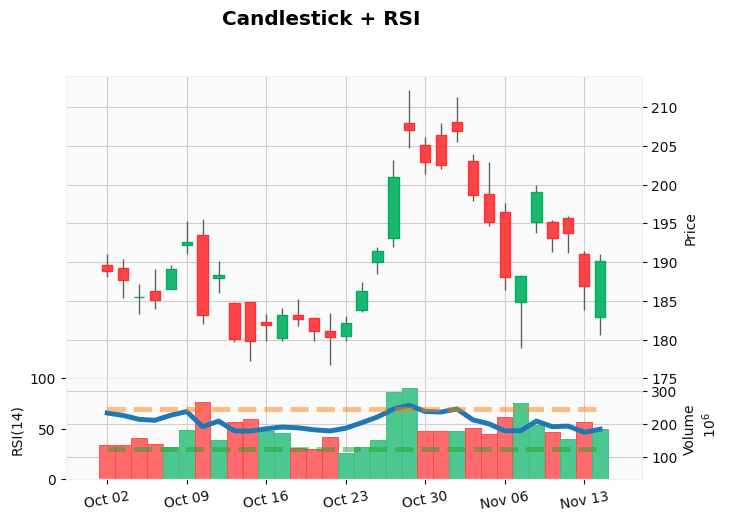

In [14]:

apds = []
if 'RSI_14' in df.columns:
    apds.append(mpf.make_addplot(df['RSI_14'], panel=1, ylabel='RSI(14)', ylim=(0,100)))
    # 30/70 guides
    apds.append(mpf.make_addplot(pd.Series(70, index=df.index), panel=1, linestyle='--', alpha=0.5))
    apds.append(mpf.make_addplot(pd.Series(30, index=df.index), panel=1, linestyle='--', alpha=0.5))

mpf.plot(
    df[['Open','High','Low','Close'] + (['Volume'] if 'Volume' in df.columns else [])],
    type='candle',
    volume=('Volume' in df.columns),
    addplot=apds,
    panel_ratios=[3,1],
    style='yahoo',
    title='Candlestick + RSI',
    ylabel='Price',
    ylabel_lower='Volume' if 'Volume' in df.columns else None,
    xrotation=10
)


## 8) Stochastic panel

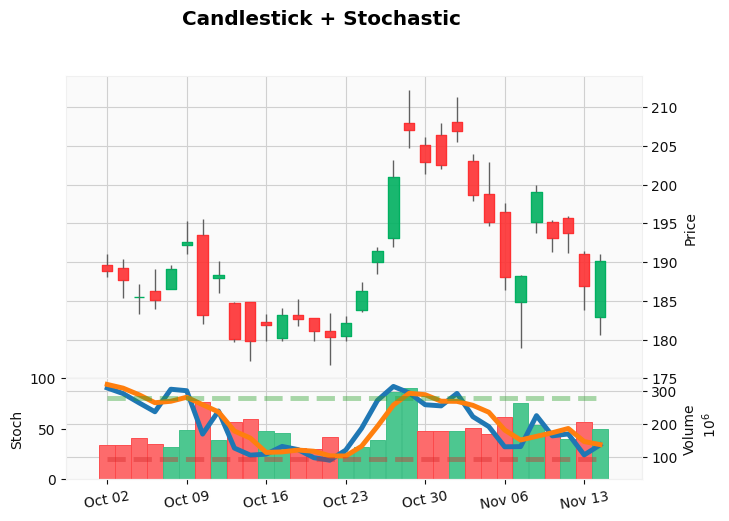

In [15]:

apds = []
if all(c in df.columns for c in ['Stoch_k','Stoch_d']):
    apds.append(mpf.make_addplot(df['Stoch_k'], panel=1, ylabel='Stoch', ylim=(0,100)))
    apds.append(mpf.make_addplot(df['Stoch_d'], panel=1, ylim=(0,100)))
    apds.append(mpf.make_addplot(pd.Series(80, index=df.index), panel=1, linestyle='--', alpha=0.4))
    apds.append(mpf.make_addplot(pd.Series(20, index=df.index), panel=1, linestyle='--', alpha=0.4))

mpf.plot(
    df[['Open','High','Low','Close'] + (['Volume'] if 'Volume' in df.columns else [])],
    type='candle',
    volume=('Volume' in df.columns),
    addplot=apds,
    panel_ratios=[3,1],
    style='yahoo',
    title='Candlestick + Stochastic',
    ylabel='Price',
    ylabel_lower='Volume' if 'Volume' in df.columns else None,
    xrotation=10
)


## 9) Extras panel (OBV, ATR, MFI, ROC, ΔClose-EMA20, High-Low Spread)

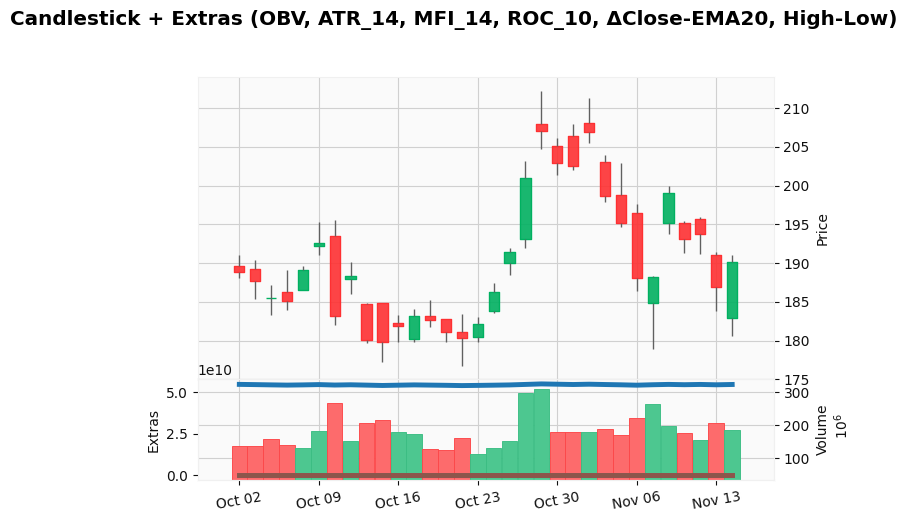

In [16]:

apds = []
labels = []

if 'OBV' in df.columns:
    apds.append(mpf.make_addplot(df['OBV'], panel=1, ylabel='Extras'))
    labels.append('OBV')
if 'ATR_14' in df.columns:
    apds.append(mpf.make_addplot(df['ATR_14'], panel=1))
    labels.append('ATR_14')
if 'MFI_14' in df.columns:
    apds.append(mpf.make_addplot(df['MFI_14'], panel=1))
    labels.append('MFI_14')
if 'ROC_10' in df.columns:
    apds.append(mpf.make_addplot(df['ROC_10'], panel=1))
    labels.append('ROC_10')
if 'Close_to_EMA20' in df.columns:
    apds.append(mpf.make_addplot(df['Close_to_EMA20'], panel=1))
    labels.append('ΔClose-EMA20')
if 'High_Low_Spread' in df.columns:
    apds.append(mpf.make_addplot(df['High_Low_Spread'], panel=1))
    labels.append('High-Low')

mpf.plot(
    df[['Open','High','Low','Close'] + (['Volume'] if 'Volume' in df.columns else [])],
    type='candle',
    volume=('Volume' in df.columns),
    addplot=apds,
    panel_ratios=[3,1],
    style='yahoo',
    title='Candlestick + Extras (' + ', '.join(labels) + ')' if labels else 'Candlestick',
    ylabel='Price',
    ylabel_lower='Volume' if 'Volume' in df.columns else None,
    xrotation=10
)


## 10) Optional: Interactive Plotly Candlestick

In [17]:

import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
)])

# Overlays: EMA and BB if present
if 'EMA_20' in df.columns:
    fig.add_scatter(x=df.index, y=df['EMA_20'], mode='lines', name='EMA 20')
if 'EMA_50' in df.columns:
    fig.add_scatter(x=df.index, y=df['EMA_50'], mode='lines', name='EMA 50')
if all(c in df.columns for c in ['BB_high','BB_low']):
    fig.add_scatter(x=df.index, y=df['BB_high'], mode='lines', name='BB High', opacity=0.5)
    fig.add_scatter(x=df.index, y=df['BB_low'],  mode='lines', name='BB Low',  opacity=0.5)

fig.update_layout(
    title='Interactive Candlestick',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)
fig.show()


## 11) Troubleshooting

In [18]:

# Common gotchas:
# - Ensure df index is DatetimeIndex (df.index) after set_index('date').
# - Column names must be exactly 'Open','High','Low','Close' (and 'Volume' if used) for mplfinance.
# - All plotted columns should be numeric; non-numeric values will be coerced to NaN.

print('Index type:', type(df.index))
print('Has OHLC:', all(c in df.columns for c in ['Open','High','Low','Close']))
print('First index value:', df.index[0] if len(df.index) else None)


Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Has OHLC: True
First index value: 2025-10-02 00:00:00
